In [1]:
# use if autocompletion is not working
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import (CountVectorizer)
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from os import getcwd, path
import os
from tqdm.autonotebook import tqdm

#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Gensim
import gensim
import gensim.corpora as corpora

# plotting
from matplotlib import pyplot as plt

import json
from typing import Dict

In [65]:
from modern_slavery_registry.utils import (
    dump_pickle,
    load_pickle)

In [5]:
RANDOM_STATE = 40

## Loading data with final cleaned statements

In [81]:
PROJECT_PATH = getcwd().replace(
    path.basename(getcwd()), "")
DATA_PATH = path.join(PROJECT_PATH, "data")
MODEL_SAVE_PATH = path.join(PROJECT_PATH, "models")
SHEETS_PATH = path.join(DATA_PATH, "sheets")
PICKLE_PATH = path.join(DATA_PATH, "pickles")

In [19]:
data = pd.read_excel(f"{SHEETS_PATH}\\subset_data.xlsx")
data.fillna("#NA", inplace=True)
data = data[["URL", "final_statement_cleaned"]]
n_sentences = len(data)
print(f"Found {n_sentences} non-NA statements")

Found 9993 non-NA statements


In [20]:
data.head()

,URL,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 km sh foor eum hold europe ltd 200 alder...
1,https://1spatial.com/who-we-are/legal/modern-s...,modern slavery act policy statement home solut...
2,https://www.shazans.com/slavery-and-human-traf...,slavery human traffic statement shazans shazan...
3,https://www.business-humanrights.org/sites/def...,28 2019 modern slavery statement 2018 make pur...
4,https://www.2agriculture.com/wp-content/upload...,fh modern slavery act 2015 human traffic state...


## Generating NGRAMS explicitly, not using Gensim NGRAMS - works like a black-box

In [9]:
NGRAMS = (1, 2)
ngrams_from_sentences = []

for sentence in tqdm(data["final_statement_cleaned"].values):
    sentence = sentence.split()
    ngrams_from_sentence = []
    len_sentence = len(sentence)
    for n in range(NGRAMS[0], NGRAMS[1]+1):
        for i in range(len_sentence-n + 1):
            ngrams_from_sentence.append(" ".join(sentence[i:i+n]))
    #     # preparing ngrams at end of sentence
    #     for i in range(len_sentence-ngram+1, len_sentence):
    #         ngram_sentence.append(" ".join(
    #             sentence[i:] + ["$PAD$"] * (ngram -  len(sentence[i :]))))
    ngrams_from_sentences.append(ngrams_from_sentence)

  0%|          | 0/9993 [00:00<?, ?it/s]

In [10]:
print(ngrams_from_sentences[0][:500])

['66', '99', 'km', 'sh', 'foor', 'eum', 'hold', 'europe', 'ltd', '200', 'aldersgate', 'street', 'london', 'ecia', '4hd', 'tel', '020', '7382', '6500', 'mail', 'keulongen', 'uk', 'kline', 'com', 'modern', 'slavery', 'act', 'transparency', 'statement', 'crane', 'lineure', 'eee', 'publish', '22', 'march', '2019', '2015', 'require', 'large', 'entity', 'carry', 'business', 'publish', 'detail', 'effort', 'combat', 'human', 'traffic', 'day', 'relate', 'action', 'activity', 'financial', 'year', 'april', '2018', '31', 'part', 'ship', 'industry', 'group', 'recognize', 'responsibility', 'take', 'robust', 'approach', 'absolutely', 'commit', 'prevent', 'corporate', 'ensure', 'supply', 'chain', 'free', 'organizational', 'structure', 'global', 'entity', 'headquarter', 'tokyo', 'japan', 'network', 'office', 'around', 'globe', 'include', 'united', 'kingdom', 'comprise', 'bulk', 'lng', 'polar', 'unit', 'include', 'car', 'carrier', 'dry', 'management', 'operation', 'train', 'relevant', 'policy', 'charter

Generating vocab from `NGRAMS`

In [11]:
ngram_term_freq = {} # to keep track of term frequency
ngram_document_freq = {} # to keep track of document-term frequency
ngram_last_doc = {}
for i, ngrams_from_sentence in tqdm(enumerate(ngrams_from_sentences)):
    for ngram in ngrams_from_sentence:  
        if ngram not in ngram_term_freq:
            ngram_term_freq[ngram] = 1
            ngram_document_freq[ngram] = 1
        else:
            ngram_term_freq[ngram] += 1
            if ngram_last_doc[ngram] != i:
                ngram_document_freq[ngram] += 1
        ngram_last_doc[ngram] = i
        
ngram_document_freq = {ngram: freq/n_sentences for ngram, freq in ngram_document_freq.items()} 
del ngram_last_doc

0it [00:00, ?it/s]

In [12]:
print(f"Vocab size: {len(ngram_term_freq)}") # without padding last ngrams word in each sentence

Vocab size: 1265192


In [13]:
ngram_stat_table = pd.DataFrame({"ngram": ngram_term_freq.keys(), 
                                 "term_freq": ngram_term_freq.values(),
                                 "doc_freq": ngram_document_freq.values()})
ngram_stat_table.describe()

,term_freq,doc_freq
count,1.265192e+06,1.265192e+06
mean,5.102946e+00,4.854976e-04
std,9.731479e+01,7.970769e-03
min,1.000000e+00,1.000700e-04
25%,1.000000e+00,1.000700e-04
50%,1.000000e+00,1.000700e-04
75%,2.000000e+00,2.001401e-04
max,1.850300e+04,9.589713e-01


Selecting vocab of interests

In [15]:
MIN_DF = 10/n_sentences # ngrams present in atleast 10 docs out of total
MAX_DF = 1000/n_sentences  # consider ngrams present in atmost 1000 docs out of total
ngram_covered = len(ngram_stat_table[ngram_stat_table["doc_freq"].between(MIN_DF, MAX_DF)])
print(f"{NGRAMS}-grams vocab size with doc frequency ({MIN_DF: .3f}, {MAX_DF: .3f}): "
      f"{ngram_covered}")
print(f"{NGRAMS}-grams vocab size with doc frequency ({MIN_DF: .3f}, {MAX_DF: .3f}): "
      f"{ngram_covered*100/len(ngram_document_freq):.3f} %")

(1, 2)-grams vocab size with doc frequency ( 0.001,  0.100): 48507
(1, 2)-grams vocab size with doc frequency ( 0.001,  0.100): 3.834 %


## Preparing data for Gensim model

In [16]:
count_vect = CountVectorizer(ngram_range=NGRAMS, min_df=MIN_DF, max_df=MAX_DF)
X = count_vect.fit_transform(data["final_statement_cleaned"].values) 
print(f"shape: {X.shape}")

shape: (9993, 48507)


In [17]:
word2idx = count_vect.vocabulary_
idx2word = {idx: word for word, idx in word2idx.items()}

data_for_model = []
for row in tqdm(X.toarray()):
    idxs = np.where(row > 0)
    data_for_model.append([(idx, row[idx]) for idx in idxs[0]])

  0%|          | 0/9993 [00:00<?, ?it/s]

In [30]:
N_TOPICS = (2, 201)
LDA_MODELS = {}
model_name_template = "sklearn_bigrams_gensim_lda"

In [31]:
%%time
# Build LDA model

for n in tqdm(range(*N_TOPICS)):
    LDA_MODELS[n] = gensim.models.ldamodel.LdaModel(
        corpus=data_for_model,
        id2word=idx2word, 
        num_topics=n,
        update_every=1,
        chunksize=1000,
        passes=1,
        alpha='auto',
        per_word_topics=True,
        iterations=50,
        random_state=RANDOM_STATE)
    dump_pickle(
        obj=LDA_MODELS[n], filename=f"{model_name_template}_{n}_topics", path=MODEL_SAVE_PATH)

  0%|          | 0/199 [00:00<?, ?it/s]

Wall time: 5h 20min 24s


In [51]:
def print_topic_keywords(
    lda_model: gensim.models.ldamodel.LdaModel,
    num_words: int=10,
    num_topics: int=-1, 
    print_: bool=False)->Dict[int, str]:
    topics_dict = {}
    for topic in lda_model.print_topics(num_words=num_words, num_topics=num_topics):
        topics_dict[topic[0]] = topic[1]
        if print_:
            print(f"{topic[0]}: {topic[1:]}")
            print()
            
    return topics_dict

In [54]:
topics = {n_topic: print_topic_keywords(LDA_MODELS[n_topic]) for n_topic in tqdm(range(*N_TOPICS))}

  0%|          | 0/199 [00:00<?, ?it/s]

In [57]:
with open(path.join(DATA_PATH, f"{model_name_template}_topics.json"), "w") as f:
    json.dump(topics, f)

In [62]:
a = print_topic_keywords(LDA_MODELS[10], print_=True)

0: ('0.003*"chain act" + 0.003*"california transparency" + 0.003*"transparency supply" + 0.002*"retaliation" + 0.002*"maintain high" + 0.002*"circumstance" + 0.002*"put place" + 0.002*"fear retaliation" + 0.002*"aim ensure" + 0.002*"specify"',)

1: ('0.002*"arrangement" + 0.002*"regulate" + 0.001*"annual turnover" + 0.001*"modern act" + 0.001*"wholly" + 0.001*"54 constitute" + 0.001*"clause" + 0.001*"software" + 0.001*"constitute financial" + 0.001*"ultimate parent"',)

2: ('0.004*"exploit" + 0.004*"violation fundamental" + 0.004*"various form" + 0.004*"liberty" + 0.004*"person liberty" + 0.003*"commercial gain" + 0.003*"deprivation" + 0.003*"crime violation" + 0.003*"liberty another" + 0.003*"knowingly"',)

3: ('0.002*"compact" + 0.002*"un" + 0.002*"ilo" + 0.002*"convention" + 0.002*"component" + 0.002*"freedom association" + 0.002*"universal" + 0.001*"grievance" + 0.001*"continuous" + 0.001*"goal"',)

4: ('0.004*"shop" + 0.004*"vehicle" + 0.003*"car" + 0.003*"store" + 0.003*"accessor

## Computing log perpexity w.r.t. to number of topics

In [70]:
LOG_PERPLEXITIES = {}
for n in tqdm(range(*N_TOPICS)):
    if n not in LOG_PERPLEXITIES.keys():
        lda_model = load_pickle(filename=f"{model_name_template}_{n}_topics", path=MODEL_SAVE_PATH)
        LOG_PERPLEXITIES[n] = lda_model.log_perplexity(data_for_model)

  0%|          | 0/199 [00:00<?, ?it/s]

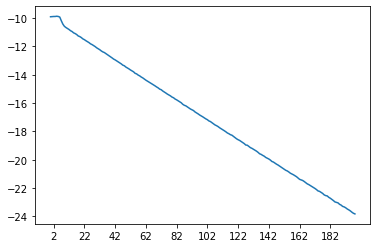

In [87]:
plt.plot(list(LOG_PERPLEXITIES.values()))
plt.xticks(range(*N_TOPICS, 20))
plt.show()

In [82]:
dump_pickle(
    LOG_PERPLEXITIES, 
    filename=f"sklearn_bigrams_gensim_lda_log_perplexities_{N_TOPICS[0]}_{N_TOPICS[1]}_topics", 
    path=PICKLE_PATH)